In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 

from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import shapiro, probplot # shapiro wilk test for normality sample size thousands or fewer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

# Import Data

In [2]:


def importdata(key, path ,parseCol, From="2004-01-01", To="2019-09-01"):
    ''' 
    make sure the end date of the parse is shared between all datasets
    '''
    dataset = pd.read_csv("%s" %(path), index_col="%s" %(parseCol), parse_dates=["%s" %(parseCol)])
    if From==None and To==None:
        pass
    elif From and To:
        dataset = dataset.loc[From:To]
    return dataset


import_PATH = r"\\ad.ucl.ac.uk\home0\zcecss0\DesktopSettings\Desktop\Research project\Data"    
meta = {# dataset: [path, Date_col, Value_col]
        "Google":[f"{import_PATH}\multiTimeline.csv", "Month", "Top5"], 
#        "RDPI":  [f"{import_PATH}\RealDisposableIncome-2004-1_Present-Mon-US(Grab-30-11-18).csv", "DATE", "DSPIC96"], 
#        "CPI":   [f"{import_PATH}\CPI.csv", "DATE", "CPI"],
#        "GDP":   [f"{import_PATH}\GDP.csv", "DATE", "GDP"], 
#        "UE":    [f"{import_PATH}\Unemployment_2004_Present_US(Grab-5-12-18).csv", "DATE", "Value"], 
        "SP500": [f"{import_PATH}\S&P500.csv", "Date", "Close"], 
#        "IR":    [f"{import_PATH}\InterestRate_2004-1-1_Present_US(Grab-5-12-18).csv", "DATE", "FEDFUNDS"], 
#        "PPI":   [f"{import_PATH}\PPIACO.csv", "DATE", "PPI"],
#        "PMI":   [f"{import_PATH}\ISM-MAN_PMI.csv", "Date", "PMI"],
        "DJI":   [f"{import_PATH}\DJI.csv", "Date", "Close"]} 

data ={}
for key in meta.keys():
    data[key] = importdata(key, meta[key][0], meta[key][1])

# Visualise Data

In [ ]:

save_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Plots_Main"
minor_locator = AutoMinorLocator(12)
for key in data.keys():
    fig, ax1 = plt.subplots()
    data[key][meta[key][2]].plot(ax=ax1,color='k').xaxis.set_minor_locator(minor_locator)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(key, color='k')
    plt.grid()
    Title = f"{key}"
#     ax2 = ax1.twinx()
#     data[key2][array2].plot(ax=ax2,color='r')
#     ax2.set_ylabel(array2, color='r')
#     ax2.tick_params('y', colors='r')
    plt.title(Title)
#    plt.savefig("%s\%s.png" %(save_PATH, Title))

1. Google data is limited to the dates ["2004-01-01":"2019-09-01"]
2. data undergoes structural break from 2008 to 2009 so model is best to be fit from 2009 onwards
3. train data is to be 95% of available data after parse

In [4]:
SP = data["SP500"]["Close"].loc["2009-01-01":"2018-12-01"]
DJI= data["DJI"]["Close"].loc["2009-01-01":"2018-12-01"]
GGL = data["Google"][meta["Google"][2]].loc["2009-01-01":"2018-12-01"]

# Data evaluation

1. Is variance constant over time? 
- Plot yearly variance (or growth rate), If growth present take logarithm
2. Is there seasonality?
- plot month's data over the years in box plot to compare seasonality
3. Is data stationary? 
- If ADF test, If no difference until stationary

# __In this section, to make the variance comparable and a relatable metric, the variances were normalised by variance.max(). Is this correct?__

#### Variance Growth

[Text(0,0.5,'var(GGL)'), Text(0.5,0,'Year index')]

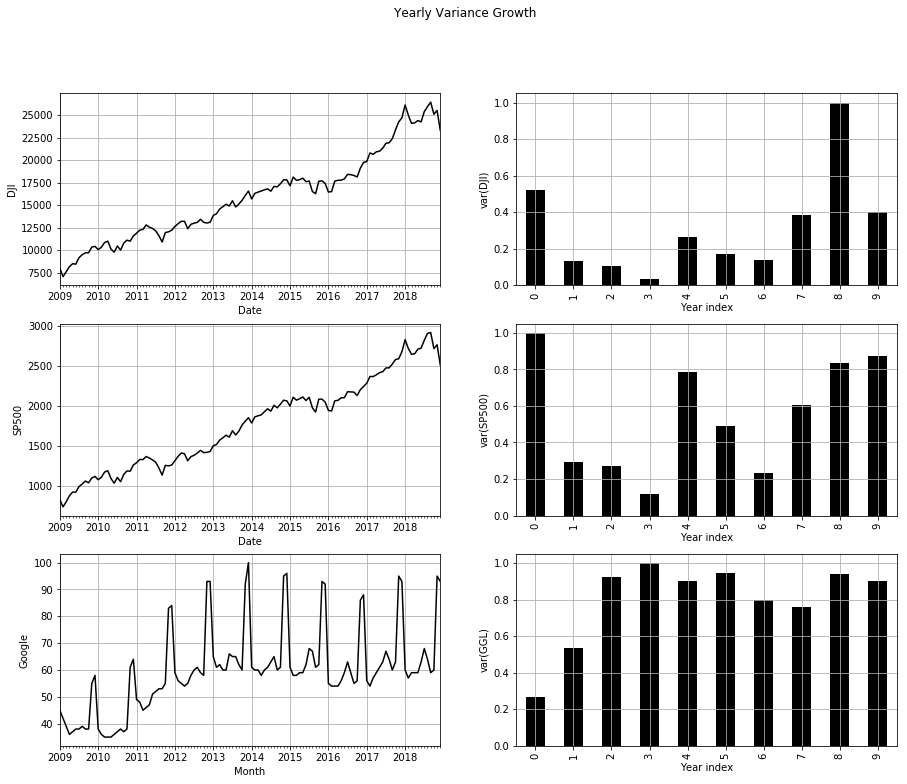

In [29]:
def var_growth_check(df):
    df_years = {}
    mm = [M for M in range(12)]
    for year in range(len(df)//12):
        val = []
        for M in mm:
            val.append(df.iloc[year*12+M])
        df_years[year] = val
    df_years = pd.DataFrame.from_dict(df_years)
    return df_years

DJI_year_var = var_growth_check(DJI)
SP_year_var = var_growth_check(SP)
GGL_year_var = var_growth_check(GGL)

fig, axes = plt.subplots(3,2,figsize=(15,12))
fig.suptitle("Yearly Variance Growth")
DJI.plot(ax=axes[0, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[0,0].set(ylabel="DJI", xlim=["2009-01-01" , "2018-12-01"])
(DJI_year_var.var()/DJI_year_var.var().max()).plot(ax=axes[0, 1],grid=True, color="k", kind="bar") # is this normalisationcorrect
axes[0, 1].set(xlabel="Year index", ylabel="var(DJI)")
# axes[0, 1].tick_params(labelbottom=False)

SP.plot(ax=axes[1, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[1,0].set(ylabel="SP500", xlim=["2009-01-01" , "2018-12-01"])
(SP_year_var.var()/SP_year_var.var().max()).plot(ax=axes[1, 1],grid=True, color="k", kind="bar")# is this normalisationcorrect
axes[1, 1].set(xlabel="Year index", ylabel="var(SP500)")
# axes[1, 1].tick_params(labelbottom=False)

GGL.plot(ax=axes[2,0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[2,0].set(ylabel="Google", xlim=["2009-01-01" , "2018-12-01"])
(GGL_year_var.var()/GGL_year_var.var().max()).plot(ax=axes[2,1], grid=True, color="k", kind="bar")
axes[2, 1].set(xlabel="Year index", ylabel="var(GGL)")
# axes[2, 1].tick_params(labelbottom=False)

# plt.savefig()


$\rightarrow$ log difference should be taken.

#### Seasonality

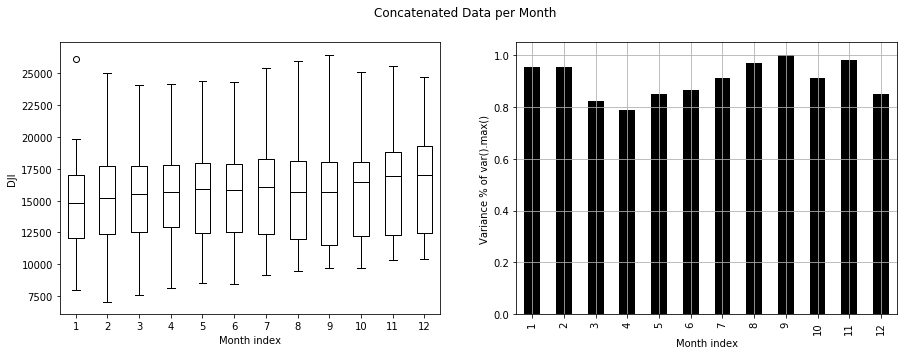

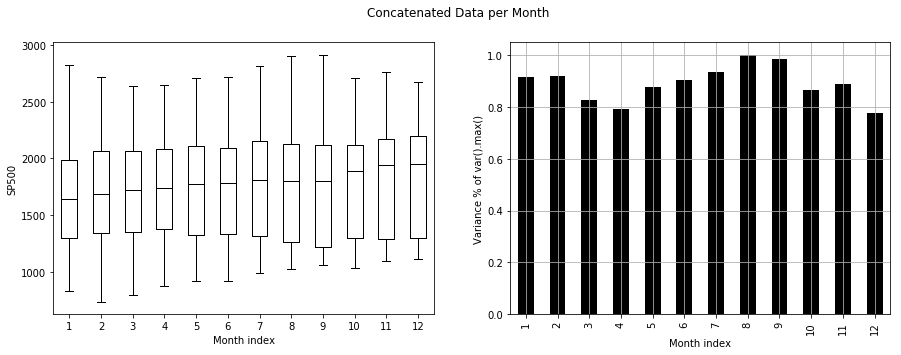

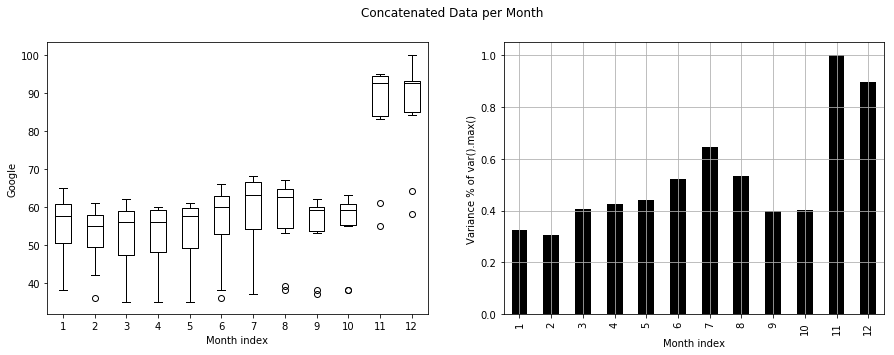

In [33]:
def seasonality_check(DF, Title, key=None, array=None, ):
    """
    data must not include incomplete years. 
    """
    if key and array: #check this line later
        df = data[key][array]
    else:
        df = DF
    mm = [M for M in range(1,13)]
    df_by_month = {}
    for M in mm:
        val = []
        for year in range(len(df)//12):
            val.append(df.iloc[year*12+M-1])
        df_by_month[M] = val
    df_by_month = pd.DataFrame.from_dict(df_by_month)    
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))   
    fig.suptitle("Concatenated Data per Month")
    df_by_month.plot(ax=axes[0], kind="box" , color="k")
    (df_by_month.var()/df_by_month.var().max()).plot(ax=axes[1], kind="bar", grid=True, color="k") # is this normalisation correct?
    axes[0].set(ylabel=f"{Title}", xlabel="Month index")
    axes[1].set(xlabel="Month index", ylabel="Variance % of var().max()")
    return df_by_month


DJI_by_month = seasonality_check(DJI, "DJI")
SP_by_month = seasonality_check(SP, "SP500")
GGL_by_month = seasonality_check(GGL, "Google")

$\rightarrow$ seasonal trend seen

#### ACF/PACF


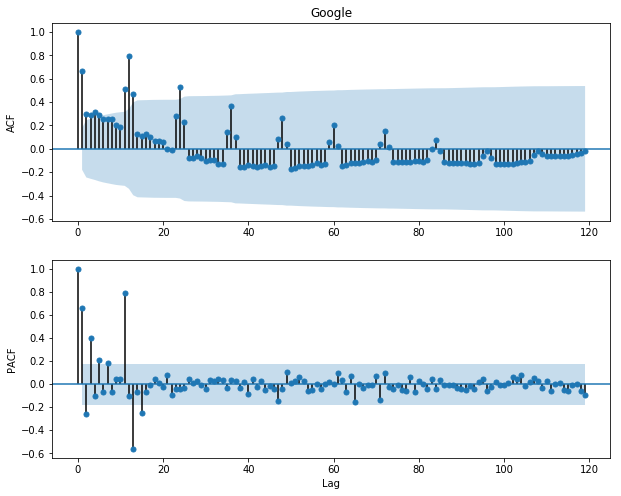

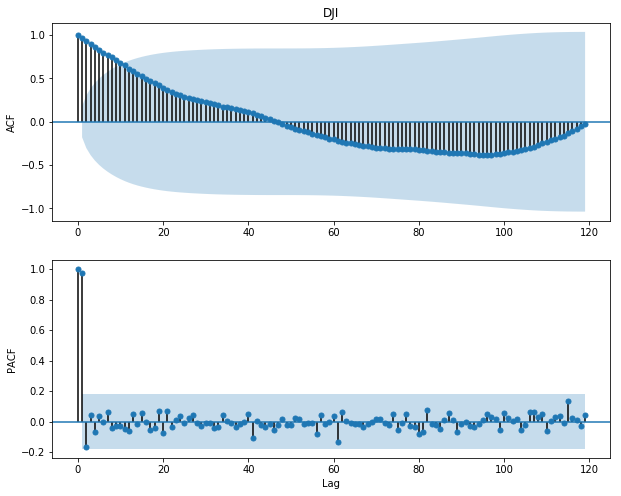

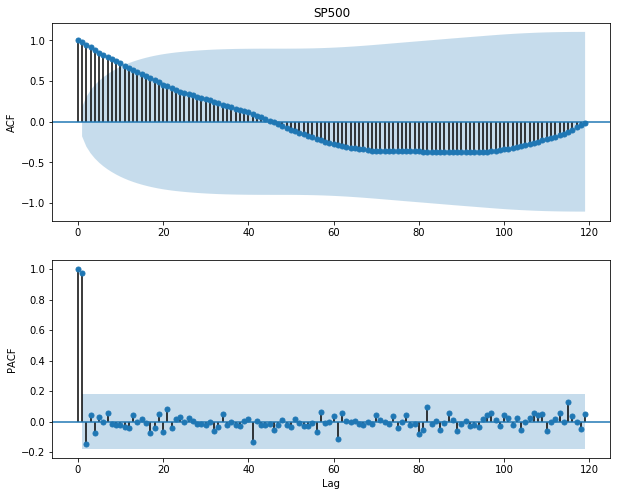

In [35]:
def acf_pacf(data, Title):
    fig, axes = plt.subplots(2,1, figsize=[10,8])
    plot_acf(data, ax=axes[0], title=f"{Title}")
    axes[0].set(ylabel="ACF")
    plot_pacf(data, method="ywmle", ax=axes[1], title="")
    axes[1].set(ylabel="PACF", xlabel="Lag")
    
acf_pacf(GGL, "Google");
acf_pacf(DJI, "DJI");
acf_pacf(SP, "SP500");


# Differencing




## Google

#WHY DOES THE LOG ADF GIVE STATIONARITY

__Dear, if you are aware ARDL and JJ cointegration test so it is better to run OLS first to check the relationship because if series are in same order integrated so JJ is appropriate and if some series are integrated at level and some are at first difference so ARDL cointegration is better one.  
However, when we take log of CPI it will turn commodity prices into inflation rate. If you are focused on prices so do not take LOG on commodity prices. __


https://davegiles.blogspot.com/2013/03/ardl-models-part-i.html

https://www.researchgate.net/post/Log_or_no_log_when_testing_for_unit_root



ADF t-Statistic: -3.313120
p-value: 0.014302
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
ADF t-Statistic: -4.198084
p-value: 0.000664
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


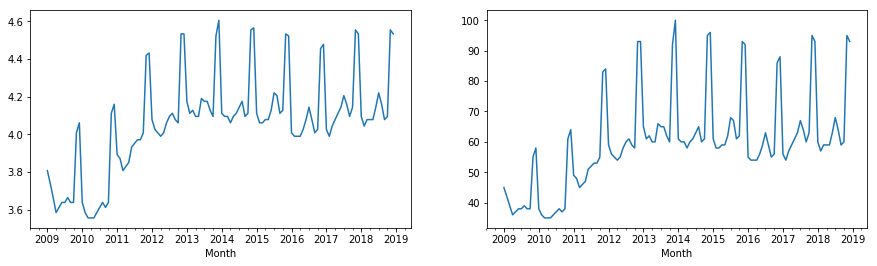

In [71]:
# test
ADF(GGL)
# ADF(GGL.diff(1).dropna())
ADF(np.log(GGL))
fig, axes = plt.subplots(1,2, figsize=[15,4])
np.log(GGL).plot(ax=axes[0])
GGL.plot(ax=axes[1])


ADF t-Statistic: -4.198084
p-value: 0.000664
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


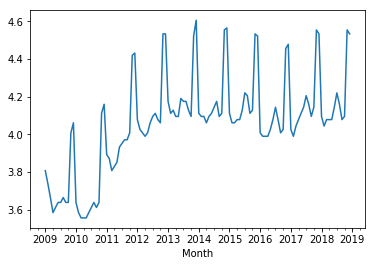

In [45]:
def ADF(array):
    ''' check for unit root errors in dataset'''
    result = adfuller(array)
    print('ADF t-Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

GGL_log = np.log(GGL)
ADF(GGL_log)
GGL_log.plot()
# GGL_seasonal_diff = GGL.diff(12).dropna()
# GGL_double_diff = GGL.diff(12).diff(1).dropna()



# ADF(GGL_seasonal_diff)
# ADF(GGL_double_diff)

$\rightarrow$ seasonal D=1 

$\rightarrow$ trend d=1

[Text(0,0.5,'PACF'), Text(0.5,0,'Lag')]

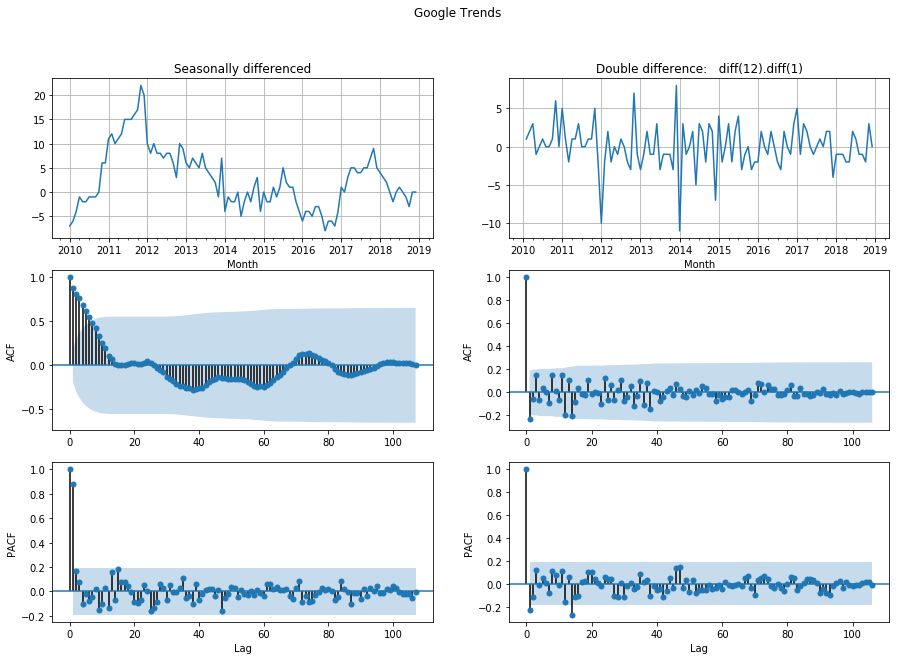

In [41]:
fig, axes = plt.subplots(3,2, figsize=[15,10])
fig.suptitle("Google Trends")
GGL_seasonal_diff.plot(ax=axes[0,0], grid=True, title="Seasonally differenced")
plot_acf(GGL_seasonal_diff, ax=axes[1,0], title="");
axes[1,0].set(ylabel="ACF")
plot_pacf(GGL_seasonal_diff, method="ywmle", ax=axes[2,0], title="");
axes[2,0].set(ylabel="PACF", xlabel="Lag")

GGL_double_diff.plot(ax=axes[0,1], grid=True, title="Double difference:   diff(12).diff(1)")
plot_acf(GGL_double_diff, ax=axes[1,1], title="");
axes[1,1].set(ylabel="ACF")
plot_pacf(GGL_double_diff, method="ywmle", ax=axes[2,1], title="");
axes[2,1].set(ylabel="PACF", xlabel="Lag")


$\rightarrow$ Start with  $GGL = ARIMA(1,1,1)(1,1,6)_{12}$


# SARIMA(p,d,q)(P,D,Q)$_m$

90% of the data is chosen as a training set and the remainder can be used as an in sample test of the fit.

# Residual Test

we need to test for normality and AC in residuals. 

# VAR and ARDL

# Forecast horizon

# Forecasting (KMC)